In [2]:
import numpy as np
import dimod
import xtools as xt
import matplotlib.pyplot as plt
from openjij import SQASampler

from IPython.display import clear_output


In [3]:
from atm.flight.generator import ScenarioGenerator, Scenario
from atm.separation import recat
from atm.flight.flight import DUMMY_FLIGHT_RECAT
from atm.optimizer.objective import *


In [4]:
cf = xt.Config(dict(
    dt=10,
    num=30,
    scenario=dict(
        interval=60,
        window=200,
        mode="mix",
        standard="recat"
    )
))


In [5]:
gen = ScenarioGenerator(cf.scenario)


In [5]:
sep = recat.TBS


In [6]:
def calc_assign_time_for_single_runway(vols, separation, indices):
    past_vol = DUMMY_FLIGHT_RECAT
    past_time = DUMMY_FLIGHT_RECAT.ready

    assigned_times = []
    for idx in indices:
        vol = vols[idx]
        sep_time = separation(past_vol, vol)
        time = np.max([vol.ready, past_time + sep_time])
        assigned_times.append(time)

        past_vol = vol
        past_time = time

    return assigned_times


In [7]:
def get_obj_multiple_runway__(vols, separation, penalty):
    def func(xs):
        print("xs:")
        print(xs)
        times = np.array([
            calc_assign_time_for_single_runway(vols, separation, xs_)
            for xs_ in xs
        ])
        readies = np.array([
            [vols[x].ready for x in xs_]
            for xs_ in xs
        ])
        dues = np.array([
            [vols[x].due for x in xs_]
            for xs_ in xs
        ])

        print("times:", type(times), times)
        print("ready:", type(readies), readies)
        delays = [times_ - readies_ for times_, readies_ in zip(times, readies)]
        print("delays")
        delay = np.mean(delays)

        overtimes = dues - times
        is_overtimes = (overtimes < 0).astype(float)
        overtime_penalty = np.sum(is_overtimes) * penalty

        return delay + overtime_penalty
    return func


In [8]:
vols = gen(10)
idxs = [
    np.arange(len(vols) // 2) * 2,
    np.arange(len(vols) // 2) * 2 + 1
]
idxs


[array([0, 2, 4, 6, 8]), array([1, 3, 5, 7, 9])]

x-sample:
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 17 20 19 22 21 23
  26 25 24 27 28 30 32 29 31 34 36 33 35 37 39 38 41 42 40 43 44 47 45 46
  48 49 50 51 52 53 54 56 55 57 58 60 59 61 63 64 62 65 66 68 67 69 71 70
  72 73 75 74 76 77 78 80 79 81 82 83 84 86 87 85 88 89 90 93 92 95 91 94
  96 97 98 99]
 [ 0  2  0  0  2  3  1  2  0  3  2  0  0  3  0  0  1  0  2  3  0  1  3  0
   0  3  1  1  3  0  2  1  0  2  2  0  3  1  1  0  2  0  3  2  3  1  3  2
   3  3  1  0  2  1  3  0  0  1  1  3  2  2  1  2  0  3  2  0  1  0  3  1
   1  2  3  0  1  2  0  1  3  3  0  2  1  3  0  2  0  2  0  2  0  2  1  1
   1  3  2  0]]
e:   12.62 sec+
p: 1.00000000
- - - - - - - - - - - - - - - - - - - - 
before-step
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 17 20 19 22 21 23
  26 25 24 27 28 30 32 29 31 34 36 33 35 37 39 38 41 42 40 43 44 47 45 46
  48 49 50 51 52 53 54 56 55 57 58 60 59 61 63 64 62 65 66 68 67 69 71 70
  72 73 75 74 76 77 78 80 79 81 82 83 84 86 87 85 88 89 90 93 

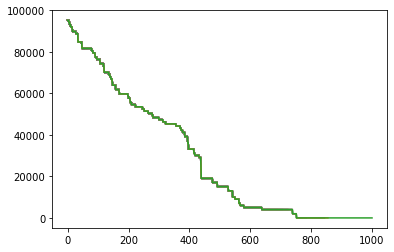

In [86]:
class MultiSequenceMetropolis:

    def __init__(self, objective, num_item, num_queue, T=1., swap_remote=False, seed=None, on_notebook=False):
        self.obj = objective
        self.nx = num_item
        self.nq = num_queue
        self.T = T
        self._swap_remote = swap_remote
        self.rs = None
        self.seed_value = self.seed(seed)
        self.on_notebook = on_notebook

        self.prob_swap_queue = 0.2

        self.ec = None
        self.best_x = None

    def seed(self, seed=None):
        self.rs = np.random.RandomState(seed)
        return seed

    def sample(self, x):
        x_ = x.copy()

        if self.prob_swap_queue >= self.rs.rand():
            print("[info] change queue")
            iter = self.rs.randint(self.nx - 1)
            x_[1, iter] = self.rs.choice([
                i for i in range(self.nq) if not i == x_[1, iter]
            ], 1)
            return x_
        else:
            print("[info] swap position")
            if self._swap_remote:
                print("[info] remote-swap")
                ixs = self.rs.choice(np.arange(self.nx), 2, replace=False)
                x_[:, ixs] = x[:, ixs[::-1]]
                return x_

            print("[info] swap-adjacent")
            iter = self.rs.randint(self.nx-1)
            x_[:, iter:iter+2] = x[:, iter:iter+2][:, ::-1]
            return x_

        return x_

    def step(self, xc):
        pass

    def accept_prob(self, ec, ep):
        de = ep - ec
        if de < 0:
            return 1
        r = np.exp(-de / self.T)
        return np.min([1, r])

    def f(self, x):
        qxs = [
            x[0, x[1,] == q]
            for q in range(self.nq)
        ]
        es = self.obj(qxs)
        return es

    def optimize(self, x0=None, num_iter=10):
        xc = x0 if x0 is not None else self.generate_base_x()
        self.ec = self.f(xc)
        pass

    @staticmethod
    def generate_base_x():
        return np.vstack([
            np.arange(len(vols)),
            np.zeros(len(vols))
        ]).astype(int)


def get_obj_multiple_runway(scenario: Scenario, separation: Separation, penalty_coef: float = 1.0) -> Callable:
    def func(xs):
        times = calc_assign_time_for_multi_runway(xs, scenario, separation)
        delays = calc_delay_for_multi_runway(xs, times, scenario)
        dues = get_due_for_multi_runway(xs, scenario)
        is_overtimes = check_over_time_for_multi_runway(times, dues)
        num_overtime = count_num_overtime(is_overtimes)

        return np.mean(np.concatenate(delays)).astype(float) + penalty_coef * num_overtime
    return func


vols = gen(100)
num_runway = 4

algo = MultiSequenceMetropolis(get_obj_multiple_runway(vols, sep, 1000), len(vols), num_runway)
# xsample = np.vstack([
#     np.arange(len(vols)),
#     np.zeros(len(vols))  # np.random.choice(np.arange(2), len(vols), replace=True)
# ]).astype(int)
xc = algo.generate_base_x()
print("xsample:")
print(xc)
print("- - - - - - - - - -")
ec = algo.f(xc)
print("f(xs) = {:7.2f} sec+".format(ec))
# algo.sample()

log_e = [ec]

clear_output()

for i in range(1000):
    print("- " * 20)
    print("before-step")
    print(xc)
    xp = algo.sample(xc)
    ep = algo.f(xp)
    r = algo.accept_prob(ec, ep)
    # if r > algo.rs.rand():
    if ep < ec:
        xc = xp
        ec = ep
        clear_output()
        plt.plot(log_e)

    log_e.append(ec)
    print("x-sample:")
    print(xp)
    print("e: {:7.2f} sec+".format(ep))
    print("p: {:10.8f}".format(r))

print("=-"*20)
print("[solution]")
print("x:")
print(xc)
print("f(x): {:7.3f}".format(ec))

plt.plot(log_e)
plt.show()


In [81]:
print(len(log_e))


301


In [6]:
vols = gen(10)
vols.to_dataframe()


,code,ready,due,category,operation
0,VOL0001,4,204,C,D
1,VOL0002,4,204,F,D
2,VOL0003,14,214,A,D
3,VOL0004,54,254,C,A
4,VOL0005,153,353,C,D
5,VOL0006,239,439,C,A
6,VOL0007,495,695,E,D
7,VOL0008,594,794,E,A
8,VOL0009,798,998,A,D
9,VOL0010,945,1145,D,D
